# Domain decomposition example using shallow water gravity wave and Dask

This example is to demonstrate how to decompose domain and run computation
on Dask's clusters using domain split API. This notebook is based on
[1_gravity_wave.ipynb](./1_gravity_wave.ipynb), and it is recommended to familiarize with it first.

## Set the grid

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from  multimodemodel import StaggeredGrid

nx, ny = 100, 100
dx, dy = 1., 1.

x = np.arange(0., dx * nx, dx)
y = np.arange(0., dy * ny, dy)

c_grid = StaggeredGrid.cartesian_c_grid(x=x, y=y)

## Set the initial state

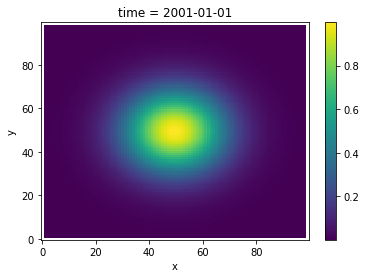

In [2]:
from multimodemodel import State, Variable, str_to_date

x, y = c_grid.eta.x, c_grid.eta.y
eta = np.exp(
    -((x - x.mean()) ** 2 + (y - y.mean()) ** 2)
    / (x.max() // 5) ** 2
)

t0 = str_to_date("2001-01-01 00:00")

initial_state = State(
    u=Variable(None, c_grid.u, t0),
    v=Variable(None, c_grid.v, t0),
    eta=Variable(eta, c_grid.eta, t0)
)
initial_state.eta.as_dataarray.plot(x='x', y='y')

## Define the problem to solve

In [3]:
from multimodemodel import (
    pressure_gradient_i,
    pressure_gradient_j,
    divergence_i,
    divergence_j,
    sum_states,
    Parameter,
)

params = Parameter(H=1.)

def non_rotating_swe(state, params):
    rhs = sum_states(
        (
            pressure_gradient_i(state, params),
            pressure_gradient_j(state, params),
            divergence_i(state, params),
            divergence_j(state, params)
        )
    )
    return rhs

## Start up dask cluster to work on

We want to split the domain into 4 parts and start a worker for each subdomain. Each worker will have two threads to be able to do asynchroneous communication.

In [4]:
from dask.distributed import LocalCluster, Client

# monkey patch to speed up dask client
from functools import lru_cache
import inspect
inspect.getsource = lru_cache(inspect.getsource)

parts = 4
domains_per_worker = 1
client = Client(
    n_workers=parts//domains_per_worker,
    threads_per_worker=domains_per_worker+1
)
workers = tuple(client.scheduler_info()["workers"].keys())
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58318,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:58332,Total threads: 2
Dashboard: http://127.0.0.1:58334/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:58322,


## Define iteration workflow

In [5]:
from multimodemodel import (
    Domain,
    Tail,
    Solver,
    Border,
    RegularSplitMerger,
    adams_bashforth3,
)
from collections import deque
from itertools import cycle

def _make_borders(base, width, dim):
    result = (
        Border.create_border(base, width, False, dim),
        Border.create_border(base, width, True, dim),
    )
    return result

def split_domain(domain, splitter, client):
    """Split domain and create borders."""
    border_width = 2
    domains = domain.split(splitter)
    domain_stack = deque(
        [[client.scatter(d, workers=w) for d, w in zip(domains, cycle(workers))]],
        maxlen=2
    )

    border_stack = deque(
        [[client.submit(_make_borders, sub, border_width, splitter.dim[0]) for sub in domain_stack[-1]]],
        maxlen=2,
    )
    return domain_stack, border_stack

def _pint(gs, domain, borders, left_neighbor_borders, right_neighbor_borders, dim):
    result = (
        gs.integrate_border(
            border=borders[0],
            domain=domain,
            neighbor_border=left_neighbor_borders[1],
            direction=False,
        ),
        gs.integrate_border(
            border=borders[1],
            domain=domain,
            neighbor_border=right_neighbor_borders[0],
            direction=True,
        ),
    )
    return result

def _int(gs, domain):
    new_domain = gs.integrate(domain)
    return new_domain

def _stitch(t, domain, borders):
    return t.stitch(domain, borders)

def run_distributed(domain, parts, rhs, step, n_step, client):
    """Split domain into parts and integrate PDEs for n_step steps."""
    dim = (domain.state.u.grid.dim_y,)
    splitter = RegularSplitMerger(parts, dim)

    domain_stack, border_stack = split_domain(domain, splitter, client=client)
    
    [tailor] = client.scatter([Tail()], broadcast=True)
    [gs] = client.scatter(
        [Solver(
            rhs=rhs,
            ts_schema=adams_bashforth3,
            step=step
        )],
        broadcast=True,
    )
    for _ in range(n_step):
        new_borders = []
        new_subdomains = []
        for i, (s, worker_of_s) in enumerate(zip(domain_stack[-1], cycle(workers))):
            borders = client.submit(
                _pint, gs, s,
                border_stack[-1][i],
                border_stack[-1][i - 1],
                border_stack[-1][(i + 1) % (splitter.parts)],
                dim[0],
                workers=worker_of_s
            )
            new_s = client.submit(_int, gs, s, workers=worker_of_s)
            new_subdomains.append(
                client.submit(_stitch, tailor, new_s, borders, workers=worker_of_s)
            )
            new_borders.append(borders)

        domain_stack.append(new_subdomains)
        border_stack.append(new_borders)

    del gs
    del tailor
    return Domain.merge(client.gather(domain_stack[-1]), splitter).state

## Perform computation

In [6]:
%%time
result = run_distributed(
    domain=Domain(state=initial_state, parameter=params),
    parts=parts,
    rhs=non_rotating_swe,
    step=0.05,
    n_step=500,
    client=client,
)

CPU times: user 7.07 s, sys: 893 ms, total: 7.96 s
Wall time: 24.8 s


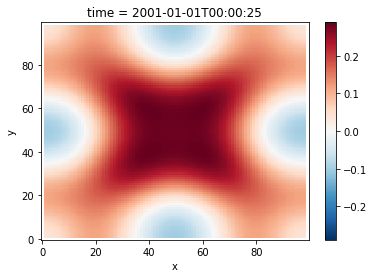

In [7]:
result.eta.as_dataarray.plot(x='x', y='y')